In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Carregar os dados 
data = fetch_california_housing(as_frame=True)
df = data.frame 
X = data.data
y_reg = data.target 

In [2]:
# Calcular a mediana do valor das casas
mediana = y_reg.median()
print(f"A mediana do valor das casas é: {mediana}")

# Criar o alvo de classificação (y)
# 1 se o valor for MAIOR que a mediana (casa 'cara')
# 0 se o valor for MENOR OU IGUAL à mediana (casa 'barata')
y = (y_reg > mediana).astype(int)

# Verificar o balanceamento das novas classes
print(y.value_counts(normalize=True))

A mediana do valor das casas é: 1.797
MedHouseVal
0    0.500145
1    0.499855
Name: proportion, dtype: float64


In [ ]:
# Definir as proporções
p_train = 0.70
p_val = 0.15
p_test = 0.15

# Separar o Teste (15%) do restante (85%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=p_test, random_state=42, stratify=y
)

# Calcular a proporção de validação em relação ao conjunto temporário
p_val_relativo = p_val / (p_train + p_val) # 0.15 / 0.85

# Separar Treino (70%) e Validação (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=p_val_relativo, random_state=42, stratify=y_temp
)

# Verificar os tamanhos
print(f"Total de dados: {len(X)}")
print(f"Treino: {len(X_train)} ({len(X_train)/len(X):.2%})")
print(f"Validação: {len(X_val)} ({len(X_val)/len(X):.2%})")
print(f"Teste: {len(X_test)} ({len(X_test)/len(X):.2%})")

Total de dados: 20640
Treino: 14448 (70.00%)
Validação: 3096 (15.00%)
Teste: 3096 (15.00%)


In [ ]:
# Definir o scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar o scaler treinado nos outros conjuntos
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Definir os modelos
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000, random_state=42), 
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') 
}

resultados = {}

for nome, modelo in modelos.items():
    print(f"--- Treinando {nome} ---")
    
    # Treinar o modelo
    modelo.fit(X_train_scaled, y_train)
    
    # Previsões no TREINO
    y_pred_train = modelo.predict(X_train_scaled)
    
    # Previsões no TESTE
    y_pred_test = modelo.predict(X_test_scaled)
    
    # Calcular métricas de Treino
    acc_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    
    # Calcular métricas de Teste
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    
    # Armazenar resultados
    resultados[nome] = {
        'Accuracy (Treino)': acc_train,
        'Accuracy (Teste)': acc_test,
        'F1 (Treino)': f1_train,
        'F1 (Teste)': f1_test
    }
    
    # Interpretação 
    print(f"Accuracy Treino: {acc_train:.4f} | Accuracy Teste: {acc_test:.4f}")
    if acc_train > (acc_test + 0.10): 
        print("Resultado: Possível Overfitting (Treino muito melhor)") 
    elif acc_train < 0.6 and acc_test < 0.6:
        print("Resultado: Possível Underfitting (Ambos baixos)")
    else:
        print("Resultado: Bom modelo (Próximos e altos)") 

# Transformar em DataFrame para a tabela final 
df_resultados = pd.DataFrame(resultados).T
print(df_resultados)

--- Treinando Regressão Logística ---
Accuracy Treino: 0.8275 | Accuracy Teste: 0.8262
Resultado: Bom modelo (Próximos e altos)
--- Treinando Random Forest ---
Accuracy Treino: 1.0000 | Accuracy Teste: 0.8999
Resultado: Possível Overfitting (Treino muito melhor)
--- Treinando XGBoost ---
Accuracy Treino: 0.9810 | Accuracy Teste: 0.9109
Resultado: Bom modelo (Próximos e altos)
                     Accuracy (Treino)  Accuracy (Teste)  F1 (Treino)  \
Regressão Logística           0.827450          0.826227     0.827748   
Random Forest                 1.000000          0.899871     1.000000   
XGBoost                       0.981035          0.910853     0.981046   

                     F1 (Teste)  
Regressão Logística    0.825325  
Random Forest          0.899481  
XGBoost                0.910853  


c:\Users\nicol\OneDrive\Documentos\IFPI\ADS\TEP\venv\lib\site-packages\xgboost\training.py:199: UserWarning: [08:29:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Calcula a AUC-ROC para cada modelo


kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_resultados = {}

for nome, modelo in modelos.items():
    scores = cross_val_score(modelo, X_train_scaled, y_train, cv=kf, scoring='roc_auc')
    
    cv_resultados[nome] = {
        'CV AUC (Média)': scores.mean(),
        'CV AUC (Std Dev)': scores.std() 
    }
    
    print(f"--- {nome} (Cross-Validation) ---")
    print(f"Scores AUC: {scores}")
    print(f"Média: {scores.mean():.4f} | Desvio Padrão: {scores.std():.4f}") 
    if scores.std() > 0.05:
        print("Interpretação: O modelo pode ser instável.") # 
    else:
        print("Interpretação: O modelo parece estável.") # 

# Adicionar ao DataFrame de resultados
df_cv = pd.DataFrame(cv_resultados).T
df_resultados = df_resultados.join(df_cv)

--- Regressão Logística (Cross-Validation) ---
Scores AUC: [0.90726505 0.90177293 0.90914124 0.91687623 0.91660516]
Média: 0.9103 | Desvio Padrão: 0.0058
Interpretação: O modelo parece estável.
--- Random Forest (Cross-Validation) ---
Scores AUC: [0.95579747 0.95388813 0.95891149 0.95576521 0.96259767]
Média: 0.9574 | Desvio Padrão: 0.0031
Interpretação: O modelo parece estável.


c:\Users\nicol\OneDrive\Documentos\IFPI\ADS\TEP\venv\lib\site-packages\xgboost\training.py:199: UserWarning: [08:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\nicol\OneDrive\Documentos\IFPI\ADS\TEP\venv\lib\site-packages\xgboost\training.py:199: UserWarning: [08:30:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\nicol\OneDrive\Documentos\IFPI\ADS\TEP\venv\lib\site-packages\xgboost\training.py:199: UserWarning: [08:30:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\nicol\OneDrive\Documentos\IFPI\ADS\TEP\venv\lib\site-packages\xgboost\training.py:199: UserWarning: [08:30:01] WARNING: C:\actions-runne

--- XGBoost (Cross-Validation) ---
Scores AUC: [0.96336579 0.95708783 0.96823478 0.96613255 0.96866721]
Média: 0.9647 | Desvio Padrão: 0.0042
Interpretação: O modelo parece estável.


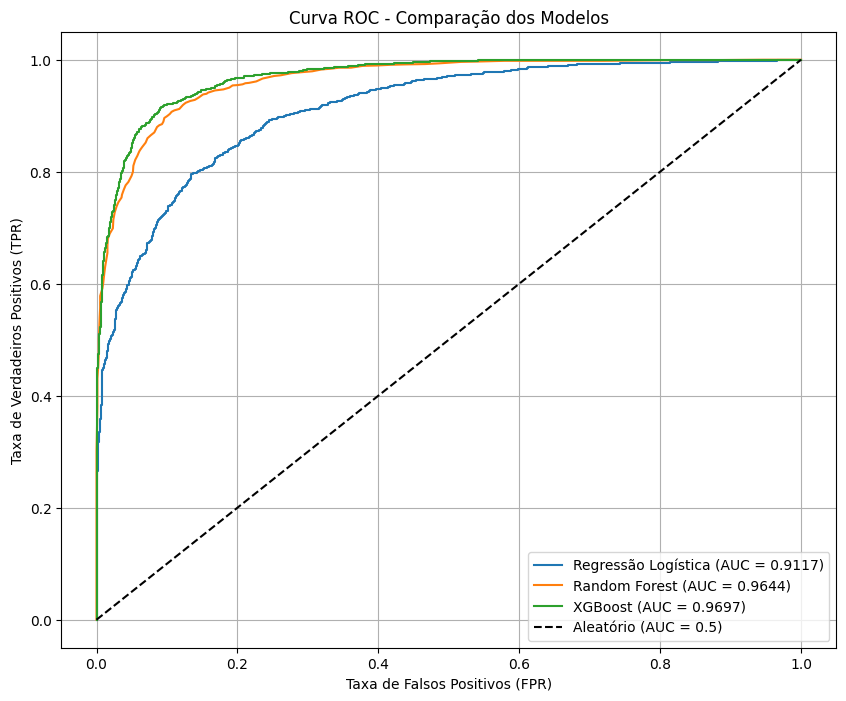

In [ ]:
plt.figure(figsize=(10, 8))

auc_scores = {}

for nome, modelo in modelos.items():
    # Obter probabilidades para a classe positiva 
    y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    
    # Calcular AUC
    auc_score = roc_auc_score(y_test, y_proba) 
    auc_scores[nome] = {'AUC (Teste)': auc_score}
    
    # Calcular FPR e TPR para a curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba) 
    
    # Plotar a curva ROC 
    plt.plot(fpr, tpr, label=f'{nome} (AUC = {auc_score:.4f})')

# Linha de referência (aleatória) 
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Comparação dos Modelos')
plt.legend()
plt.grid()
plt.show()

# Adicionar ao DataFrame de resultados
df_auc = pd.DataFrame(auc_scores).T
df_resultados = df_resultados.join(df_auc)

In [ ]:
gen_resultados = {}

for nome, modelo in modelos.items():
    # Avaliar no conjunto de VALIDAÇÃO
    y_pred_val = modelo.predict(X_val_scaled)
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    
    gen_resultados[nome] = {
        'Accuracy (Generalização)': acc_val,
        'F1 (Generalização)': f1_val
    }
    
    print(f"--- {nome} (Teste de Generalização) ---")
    print(f"Performance no Teste: {resultados[nome]['Accuracy (Teste)']:.4f}")
    print(f"Performance na Validação: {acc_val:.4f}")
    if np.isclose(resultados[nome]['Accuracy (Teste)'], acc_val, atol=0.03):
        print("Interpretação: O desempenho se mantém consistente.") # 
    else:
        print("Interpretação: O desempenho caiu/mudou nos novos dados.")

# Adicionar ao DataFrame de resultados
df_gen = pd.DataFrame(gen_resultados).T
df_resultados = df_resultados.join(df_gen)

--- Regressão Logística (Teste de Generalização) ---
Performance no Teste: 0.8262
Performance na Validação: 0.8146
Interpretação: O desempenho se mantém consistente.
--- Random Forest (Teste de Generalização) ---
Performance no Teste: 0.8999
Performance na Validação: 0.8915
Interpretação: O desempenho se mantém consistente.
--- XGBoost (Teste de Generalização) ---
Performance no Teste: 0.9109
Performance na Validação: 0.9057
Interpretação: O desempenho se mantém consistente.


In [29]:
# --- CÉLULA 9: Exibir Tabela Final em Markdown ---
print("--- Tabela Comparativa Final (Markdown) ---")

# 1. Arredondar os valores
df_resultados_rounded = df_resultados.round(4)


# Renomeia apenas as colunas que existem
df_tabela_formatada = df_resultados_rounded

# 3. Use .to_markdown() para formatar a saída
# floatfmt=".4f" garante que os números fiquem com 4 casas decimais
print(df_tabela_formatada.to_markdown(floatfmt=".4f"))

--- Tabela Comparativa Final (Markdown) ---
|                     |   Accuracy (Treino) |   Accuracy (Teste) |   F1 (Treino) |   F1 (Teste) |   CV AUC (Média) |   CV AUC (Std Dev) |   AUC (Teste) |   Accuracy (Generalização) |   F1 (Generalização) |   Gen_Diff |
|:--------------------|--------------------:|-------------------:|--------------:|-------------:|-----------------:|-------------------:|--------------:|---------------------------:|---------------------:|-----------:|
| Regressão Logística |              0.8275 |             0.8262 |        0.8277 |       0.8253 |           0.9103 |             0.0058 |        0.9117 |                     0.8146 |               0.8147 |     0.0116 |
| Random Forest       |              1.0000 |             0.8999 |        1.0000 |       0.8995 |           0.9574 |             0.0031 |        0.9644 |                     0.8915 |               0.8903 |     0.0084 |
| SVM (SVC)           |              0.8611 |             0.8618 |        0.8608

In [30]:
# GERAR RELATÓRIO PDF 
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

# Suprimir warnings para um PDF limpo
warnings.filterwarnings('ignore')

pdf_filename = "Relatorio_Modelos.pdf"

# PREPARAR O DATAFRAME DA TABELA
df_resultados_rounded = df_resultados.round(4)

# Limpar colunas de cálculo 
if 'Gen_Diff' in df_resultados_rounded.columns:
    df_tabela_limpa = df_resultados_rounded.drop(columns=['Gen_Diff'])
else:
    df_tabela_limpa = df_resultados_rounded.copy()

# Renomear colunas 
novos_nomes = {
    'Accuracy (Treino)': 'Accuracy\n(Treino)',
    'Accuracy (Teste)': 'Accuracy\n(Teste)',
    'F1 (Treino)': 'F1\n(Treino)',
    'F1 (Teste)': 'F1\n(Teste)',
    'CV AUC (Média)': 'CV AUC\n(Média)',
    'CV AUC (Std Dev)': 'CV AUC\n(Std Dev)',
    'AUC (Teste)': 'AUC\n(Teste)',
    'Accuracy (Generalização)': 'Accuracy\n(Gener.)',
    'F1 (Generalização)': 'F1\n(Gener.)'
}

# Renomeia apenas as colunas que existem no dataframe
df_tabela_formatada = df_tabela_limpa.rename(columns=novos_nomes)
# -----------------------------

# CRIAR O ARQUIVO PDF 
with PdfPages(pdf_filename) as pdf:
    
    # --- Página 1: Gráfico ROC ---
    fig_roc = plt.figure(figsize=(10, 8))
    
    for nome, modelo in modelos.items():
        y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{nome} (AUC = {auc_score:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('1. Curva ROC - Comparação dos Modelos')
    plt.legend()
    plt.grid(True)
    
    pdf.savefig(fig_roc, bbox_inches='tight')
    plt.close(fig_roc)

    # --- Página 2: Tabela Comparativa ---
    fig_table = plt.figure(figsize=(11.69, 8.27)) # A4 Paisagem
    fig_table.suptitle('2. Tabela Comparativa Final', fontsize=16)
    
    ax_table = fig_table.add_subplot(111)
    ax_table.axis('off')

    # Ajuste de larguras das colunas
    col_widths = [0.18] + [0.09] * len(df_tabela_formatada.columns)

    the_table = pd.plotting.table(
        ax_table, 
        df_tabela_formatada,
        loc='center', 
        colWidths=col_widths,
        cellLoc='center', 
        rowLoc='center'
    )
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(8.5)
    the_table.scale(1.0, 2.0) 

    # Salvar Página 2
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close(fig_table)

print(f"Relatório visual salvo com sucesso em '{pdf_filename}'")

Relatório visual salvo com sucesso em 'Relatorio_Modelos.pdf'
